<a href="https://colab.research.google.com/github/afdebbas/DataScience/blob/master/Classification_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# https://gitlab.com/ppleskov/kaggle-days-dubai

# Ultimate Binary Classification Pipeline

## by Pavel Pleskov - Data Scientist at Point API (https://pointapi.com/)


https://hackernoon.com/interview-with-kaggle-grandmaster-data-scientist-at-point-api-pavel-pleskov-cc8ca67de249

## Example

- Humpback Whale Identification https://www.kaggle.com/c/humpback-whale-identification/discussion/82430#latest-482102
- Gendered Pronoun Resolution https://www.kaggle.com/c/gendered-pronoun-resolution/discussion/90417#latest-522210

## Motivation

- a lot of algorithms in sklearn and in other libraries, how to choose?
- trade-off between computation time and quality/diversity
- proper parameter tuning
- blending/stacking

## What will not be covered

- Naive Bayes, FFM
- imbalanced classes
- feature engineering
- setting up GPU for boosters

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
import random 

from os import listdir
from tqdm import tqdm
from os.path import isfile

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD

from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
print()
print("lightgbm:", lgb.__version__)
print("xgboost:", xgb.__version__)
print("catboost:", cb.__version__)

# pip install bayesian-optimization 
# pip install catboost

pandas: 0.24.2
numpy: 1.16.3
sklearn: 0.20.1

lightgbm: 2.2.3
xgboost: 0.82
catboost: 0.14.2


## Downloading the data

Homesite Quote Conversion

https://www.kaggle.com/c/homesite-quote-conversion/data

Please follow the link and accept the rules!

In [0]:
unzip input/homesite-quote-conversion.zip

## Preprocessing

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Using train 10% subsample in order to fit RAM on laptop

In [0]:
train = train.sample(frac=0.1, random_state=42) # comment if you want to run on entire set (takes longer time)
train.reset_index(drop=True, inplace=True)

Dataset seems to be balanced enough

In [0]:
train.QuoteConversion_Flag.value_counts()

0    21180
1     4895
Name: QuoteConversion_Flag, dtype: int64

Dealing with dates and categorical variables

In [0]:
# https://www.kaggle.com/tunguz/xgboost-benchmark-1

y = train.QuoteConversion_Flag.values
train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
test = test.drop('QuoteNumber', axis=1)

# Lets play with some dates
train['Date'] = pd.to_datetime(pd.Series(train['Original_Quote_Date']))
train = train.drop('Original_Quote_Date', axis=1)

test['Date'] = pd.to_datetime(pd.Series(test['Original_Quote_Date']))
test = test.drop('Original_Quote_Date', axis=1)

train['Year'] = train['Date'].apply(lambda x: int(str(x)[:4]))
train['Month'] = train['Date'].apply(lambda x: int(str(x)[5:7]))
train['weekday'] = train['Date'].dt.dayofweek

test['Year'] = test['Date'].apply(lambda x: int(str(x)[:4]))
test['Month'] = test['Date'].apply(lambda x: int(str(x)[5:7]))
test['weekday'] = test['Date'].dt.dayofweek

train = train.drop('Date', axis=1)
test = test.drop('Date', axis=1)

train = train.fillna(-1)
test = test.fillna(-1)

for f in tqdm(train.columns):
    if train[f].dtype=='object':
        #print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
        
# train-test discrepancy analysis is skipped

100%|██████████| 299/299 [00:03<00:00, 91.48it/s]


In [0]:
train.tail()

,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,...,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Year,Month,weekday
26070,5,3,0.8945,0.0038,5,1.0670,0,10,17,10,...,20,-1,12,-1,21,1,2,2013,3,0
26071,2,17,0.8746,0.0006,3,1.3045,1,7,11,7,...,15,-1,10,-1,13,1,1,2015,4,6
26072,5,22,1.0101,0.0040,4,1.2694,0,7,11,7,...,16,-1,19,-1,12,1,2,2015,5,4
26073,5,3,0.9023,0.0038,5,1.0670,0,4,4,4,...,7,-1,15,-1,14,1,2,2013,2,2
26074,1,25,0.9153,0.0007,6,1.0200,0,22,25,22,...,10,-1,16,-1,22,1,0,2014,7,0


In [0]:
cols = list(train.columns)
len(cols), cols

(299,
 ['Field6',
  'Field7',
  'Field8',
  'Field9',
  'Field10',
  'Field11',
  'Field12',
  'CoverageField1A',
  'CoverageField1B',
  'CoverageField2A',
  'CoverageField2B',
  'CoverageField3A',
  'CoverageField3B',
  'CoverageField4A',
  'CoverageField4B',
  'CoverageField5A',
  'CoverageField5B',
  'CoverageField6A',
  'CoverageField6B',
  'CoverageField8',
  'CoverageField9',
  'CoverageField11A',
  'CoverageField11B',
  'SalesField1A',
  'SalesField1B',
  'SalesField2A',
  'SalesField2B',
  'SalesField3',
  'SalesField4',
  'SalesField5',
  'SalesField6',
  'SalesField7',
  'SalesField8',
  'SalesField9',
  'SalesField10',
  'SalesField11',
  'SalesField12',
  'SalesField13',
  'SalesField14',
  'SalesField15',
  'PersonalField1',
  'PersonalField2',
  'PersonalField4A',
  'PersonalField4B',
  'PersonalField5',
  'PersonalField6',
  'PersonalField7',
  'PersonalField8',
  'PersonalField9',
  'PersonalField10A',
  'PersonalField10B',
  'PersonalField11',
  'PersonalField12',
  'P

## Scaler

In [0]:
scaler = StandardScaler() #MinMaxScaler StandardScaler RobustScaler

train[cols] = scaler.fit_transform(train[cols])
# test[cols] = scaler.transform(test[cols])

/home/pavel/anaconda3/envs/py365/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/pavel/anaconda3/envs/py365/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Using column subsample in order to speed calulation up

In [0]:
# Naive approach
# random.seed(42)
# cols = random.sample(cols, 50) 

In [0]:
N = 50

svd = TruncatedSVD(n_components=N, random_state=42)
X = svd.fit_transform(train[cols], y)  
svd.explained_variance_ratio_.sum()

0.769835802806167

In [0]:
df = pd.DataFrame()
df["target"] = y

for i in range(50):
    df[i] = X[:,i]
    
df.to_csv("partial_train_"+str(N)+".csv", index=False)

df.tail()

,target,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
26070,0,-2.697430,-7.176321,-4.441157,-0.696278,-0.254173,0.567101,0.191361,0.785564,-0.217400,...,1.642036,-1.081729,0.319332,-1.769774,-0.065820,0.911199,-0.097105,0.144381,-0.295786,0.172246
26071,0,-5.021211,-3.199173,-1.293690,-0.833889,0.541229,5.038471,1.658618,-5.354749,-1.116558,...,-0.358473,-1.572445,-0.068892,-0.529101,0.606700,-0.549447,0.304709,0.591064,-0.129661,0.558340
26072,0,-2.839973,-0.455769,-5.036594,-1.508620,-3.315193,0.394648,0.232433,3.063184,-1.654045,...,0.332677,-0.920742,1.737735,1.120053,0.309615,-0.718849,0.380552,0.419170,-0.888988,1.177033
26073,1,-2.910019,-0.630014,-7.747027,-1.024270,-0.340097,3.986513,-1.015409,0.918555,-0.505734,...,-0.806945,-0.513780,-0.070973,0.951900,-0.028200,0.535365,-0.276189,0.431672,-0.180558,1.095553
26074,0,6.653140,0.397828,4.980203,-1.230184,-4.275555,-4.811223,1.094970,2.285175,0.682350,...,1.591038,0.857429,-3.050250,0.893820,-0.004001,-0.206528,-0.849533,2.255292,0.343791,0.762498


## LogReg

In [0]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "reg"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    reg = LogisticRegression(C=1,
                             solver="newton-cg", 
                             penalty="l2", 
                             n_jobs=-1, 
                             max_iter=100).fit(X_train, y_train) 
    
    y_pred = reg.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.83471
1 ROC AUC: 0.81989
2 ROC AUC: 0.84066
3 ROC AUC: 0.83345
4 ROC AUC: 0.82029

OOF ROC AUC: 0.82978

CPU times: user 313 ms, sys: 746 ms, total: 1.06 s
Wall time: 6.09 s


In [0]:
??LogisticRegression

## SVM

In [0]:
# https://github.com/Xtra-Computing/thundergbm
# pip install thundersvm-cpu-0.2.0-py3-none-linux_x86_64.whl
# from thundersvm import SVC

In [0]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "svc"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    svc = SVC(C=0.1, 
              # gamma="scale",
              max_iter=1000,
              probability=True).fit(X_train, y_train) 
    
    y_pred = svc.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

## KNN

In [0]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "nei"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    nei = KNeighborsClassifier(n_neighbors=100,
                               p=1, n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = nei.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    
print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.82351
1 ROC AUC: 0.82367
2 ROC AUC: 0.82949
3 ROC AUC: 0.82314
4 ROC AUC: 0.82463

OOF ROC AUC: 0.82479

CPU times: user 2min 36s, sys: 315 ms, total: 2min 37s
Wall time: 45.1 s


## Random Forest

In [0]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "rfc"

train[arch] = 0
test[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    rfc = RandomForestClassifier(n_estimators=100,
                                 criterion='gini',
                                 n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = rfc.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.84761
1 ROC AUC: 0.83931
2 ROC AUC: 0.85057
3 ROC AUC: 0.85199
4 ROC AUC: 0.84764

OOF ROC AUC: 0.84751

CPU times: user 2min 4s, sys: 286 ms, total: 2min 4s
Wall time: 35 s


## LGBM

In [0]:
%%time

arch = "lgb"

train[arch] = 0

rounds = 10000
early_stop_rounds = 300

params = {'objective': 'binary',
          'boosting_type': 'gbrt',
          'metric': 'auc',
          'seed': 42,
          'max_depth': -1,
          'verbose': -1,
          'n_jobs': -1}

# best_params = {'feature_fraction': 0.8752556106728574,
#               'lambda_l1': 1.3735569040447826,
#               'lambda_l2': 8.04774809406042,
#               'learning_rate': 0.024553401275571943,
#               'min_data_in_leaf': 16.31456193667883,
#               'min_sum_hessian_in_leaf': 10.489617646270466,
#               'num_leaves': 14.623398745206696}

# best_params['num_leaves'] = int(best_params['num_leaves'])
# best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
# params.update(best_params)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]

    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid)    

    model = lgb.train(params,
                      d_train,
                      num_boost_round=rounds,
                      valid_sets=[d_train, d_valid],
                      valid_names=['train','valid'],
                      early_stopping_rounds=early_stop_rounds,
                      verbose_eval=0) 

    joblib.dump(model, "./output/lgb_"+str(i)+".pkl")

    y_pred = model.predict(X_valid)
    train.loc[valid_index, arch] = y_pred
    auc = roc_auc_score(y_valid, y_pred)
    print(i, "ROC AUC:", round(auc, 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.88592
1 ROC AUC: 0.8725
2 ROC AUC: 0.88379
3 ROC AUC: 0.88334
4 ROC AUC: 0.87745

OOF ROC AUC: 0.87938

CPU times: user 3min, sys: 655 ms, total: 3min
Wall time: 47 s


## Feature importance

Text(0.5,1,'Light GBM Feature Importance')

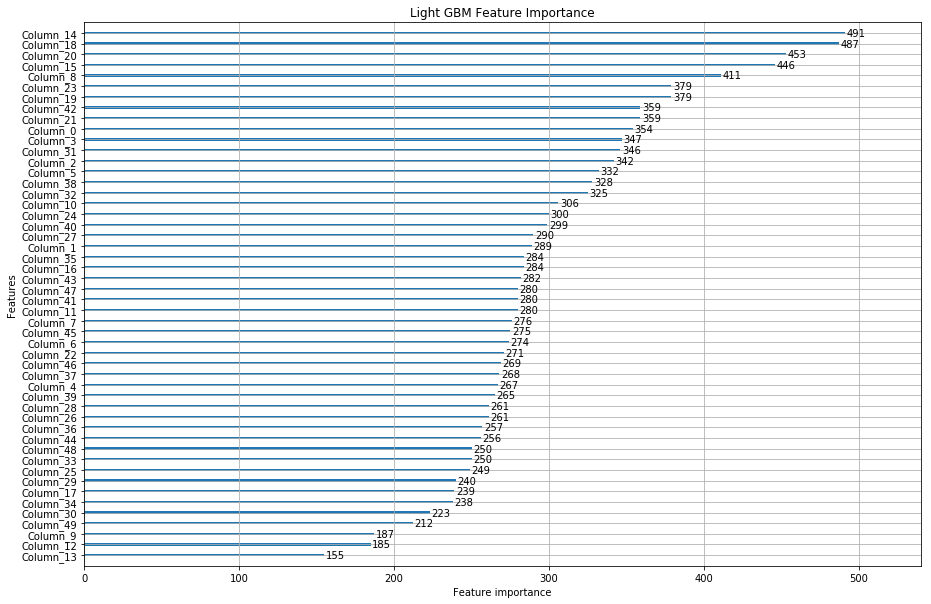

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

model = joblib.load("./output/lgb_0.pkl")

fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

## HPO

In [0]:
def evaluate(**new_params):

    rounds = 10000
    early_stop_rounds = 300
    
    new_params['num_leaves'] = int(new_params['num_leaves'])
    new_params['min_data_in_leaf'] = int(new_params['min_data_in_leaf'])
    
    params.update(new_params)
    print(new_params)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof = np.zeros(len(train))
    
    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
        X_train = X[train_index]
        X_valid = X[valid_index]

        y_train = y[train_index]
        y_valid = y[valid_index]

        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_valid, y_valid)    

        model = lgb.train(params,
                          d_train,
                          num_boost_round=rounds,
                          valid_sets=[d_train, d_valid],
                          valid_names=['train','valid'],
                          early_stopping_rounds=early_stop_rounds,
                          verbose_eval=0) 
        
        oof[valid_index] = model.predict(X_valid)
        auc = roc_auc_score(y[valid_index], oof[valid_index])
        print(i, "ROC AUC:", round(auc, 5))
    
    auc = roc_auc_score(y, oof)
    print()
    print("ROC AUC VALID:", round(auc, 5))
    print()
        
    return auc

In [0]:
# https://github.com/fmfn/BayesianOptimization

params = {'objective': 'binary',
          'boosting_type': 'gbrt',
          'metric': 'auc',
          'bagging_freq': 1,
          'bagging_fraction': 0.9,
          'bagging_seed': 42,
          'seed': 42,
          'max_bin': 1023, #255
          'max_depth': -1,
          'verbose': -1,
          'n_jobs': -1}

bounds = {'num_leaves': (4,32), 
          'min_sum_hessian_in_leaf': (0,20), 
          'min_data_in_leaf': (10,30), 
          'learning_rate': (0.01,0.05), 
          'lambda_l2': (0,20), 
          'lambda_l1': (0,5), 
          'feature_fraction': (0.0,1.0)}

bo = BayesianOptimization(evaluate, pbounds=bounds)

log_file = "./output/hpo_lgbm_logs.json"
logger = JSONLogger(path=log_file)
bo.subscribe(Events.OPTMIZATION_STEP, logger)

# bo.maximize(init_points=2, n_iter=8)

In [0]:
# bo.max

## XGB

In [0]:
%%time

arch = "xgb"

train[arch] = 0

rounds = 10000
early_stop_rounds = 100

params = {'eval_metric': 'auc',
          'booster': 'gbtree',
          'tree_method': 'hist',
          'objective': 'binary:logistic',
          'subsample': 0.9,
          'colsample_bytree': 0.3,
          'eta': 0.1,
          'max_depth': 4,
          'seed': 42,
          'verbosity': 0}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)

    model = xgb.train(params,
                      d_train,
                      rounds,
                      [(d_train, 'train'), (d_valid, 'eval')],
                      early_stopping_rounds=early_stop_rounds,
                      verbose_eval=0)
    
    #joblib.dump(model, f"./output/xgb_{i}.pkl")

    best = model.best_iteration + 1

    y_pred = model.predict(d_valid, ntree_limit=best)
    train.loc[valid_index, arch] = y_pred
    auc = roc_auc_score(y_valid, y_pred)
    print(i, "ROC AUC:", round(auc, 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

KeyboardInterrupt: 

## CatBoost

In [0]:
%%time

arch = "cat"

train[arch] = 0

rounds = 10000
early_stop_rounds = 100

params = {'task_type': 'CPU', #GPU
          'iterations': rounds,
          'loss_function': 'Logloss',
          'eval_metric':'AUC',
          'random_seed': 42,
          'learning_rate': 0.5,
          'depth': 2}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    trn_data = Pool(X_train, y_train)
    val_data = Pool(X_valid, y_valid)
    
    clf = CatBoostClassifier(**params)
    clf.fit(trn_data,
            eval_set=val_data,
            use_best_model=True,
            early_stopping_rounds=early_stop_rounds,
            verbose=0)
    
    y_pred = clf.predict_proba(X_valid)[:, 1]
    train.loc[valid_index, arch] = y_pred
    auc = roc_auc_score(y_valid, y_pred)
    print(i, "ROC AUC:", round(auc, 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

KeyboardInterrupt: 

## NN

In [0]:
import fastai
import torch

from fastai.basic_data import load_data
from fastai.tabular import *

print("fastai:", fastai.__version__)
print("torch:", torch.__version__)

fastai: 1.0.51
torch: 1.0.1.post2


In [0]:
path = Path('../output/')
bs = 2048

procs = [FillMissing, Categorify, Normalize]

dep_var = "target"

cat_names = []
cont_names = []

df = pd.read_csv("partial_train_"+str(N)+".csv")
cont_names = list(df.columns)
cont_names.remove('target')

In [0]:
def auc_score(y_pred,y_true,tens=True):
    score = roc_auc_score(y_true, torch.sigmoid(y_pred)[:, 1])
    if tens:
        score = tensor(score)
    else:
        score = score
    return score

random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [0]:
%%time

arch = "nn"

train[arch] = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    data = (TabularList.from_df(df, path=path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs)
                       .split_by_idx(valid_index)
                       .label_from_df(cols=dep_var)
                       .databunch(bs=bs))
    
    learn = tabular_learner(data, 
                            layers=[20, 10],
                            ps=0.5,
                            emb_drop=0.5,
                            y_range=[0, 1],
                            use_bn=True,
                            metrics=[auc_score])
    lr = 1e-2
    
    learn.fit_one_cycle(10, lr, moms=(0.8, 0.7))
    learn.fit_one_cycle(10, lr/2, moms=(0.8, 0.7))
        
    preds = learn.get_preds(ds_type=DatasetType.Valid)
    y_pred = [float(preds[0][i][1]) for i in range(len(preds[0]))]
    
    train.loc[valid_index, arch] = y_pred
    auc = roc_auc_score(y[valid_index], y_pred)
    print(i, "ROC AUC:", round(auc, 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.89692


epoch,train_loss,valid_loss,auc_score,time
0,0.672555,0.666784,0.565683,00:01
1,0.666272,0.643443,0.700749,00:01
2,0.642627,0.531272,0.799587,00:01
3,0.605877,0.486548,0.826364,00:01
4,0.574522,0.473371,0.849575,00:01
5,0.550462,0.461567,0.866392,00:01
6,0.531934,0.456292,0.869709,00:01
7,0.517236,0.452750,0.875713,00:01
8,0.506183,0.451402,0.877255,00:01
9,0.497262,0.451209,0.877973,00:01


epoch,train_loss,valid_loss,auc_score,time
0,0.464592,0.450519,0.879004,00:01
1,0.463511,0.448781,0.880565,00:01
2,0.462272,0.448332,0.883157,00:01
3,0.461396,0.448076,0.884185,00:01
4,0.460001,0.447582,0.881095,00:01
5,0.458901,0.444799,0.884672,00:01


KeyboardInterrupt: 

## Correlation

In [0]:
models = ["reg", "nei", "rfc", "lgb"] #, "xgb", "cat", "nn"]

for model in models:
    train[model] = train[model].rank()/len(train)

train[models].corr(method="spearman")

,reg,nei,rfc,lgb
reg,1.000000,0.849649,0.820383,0.830550
nei,0.849649,1.000000,0.835290,0.805125
rfc,0.820383,0.835290,1.000000,0.839611
lgb,0.830550,0.805125,0.839611,1.000000


In [0]:
train[models].corr()

,reg,nei,rfc,lgb
reg,1.000000,0.849649,0.820383,0.830550
nei,0.849649,1.000000,0.835290,0.805125
rfc,0.820383,0.835290,1.000000,0.839611
lgb,0.830550,0.805125,0.839611,1.000000


In [0]:
train[models].tail()

,reg,nei,rfc,lgb
26070,0.941707,0.787728,0.836817,0.888399
26071,0.468917,0.245427,0.259827,0.410125
26072,0.637392,0.563356,0.533346,0.346539
26073,0.845139,0.972733,0.964295,0.946692
26074,0.589223,0.370834,0.681457,0.224353


## Blending

In [0]:
for arch in models:
    print(arch, round(roc_auc_score(y, train[arch]), 5))

reg 0.82978
nei 0.82479
rfc 0.84751
lgb 0.87938


Let's try traditional arithmetic mean

In [0]:
train["avg"] = train[models].mean(axis=1)
print("avg", round(roc_auc_score(y, train["avg"]), 5))

avg 0.86849


Now some more advanced means

In [0]:
from scipy.stats.mstats import gmean

def power_mean(x, p=1):
    if p==0:
        return gmean(x, axis=1)
    return np.power(np.mean(np.power(x,p), axis=1), 1/p)

In [0]:
for power in [0,1,2,4,8]:
    train["avg"] = power_mean(train[models].values, power)
    print(power, round(roc_auc_score(y, train["avg"]), 5))

0 0.86793
1 0.86849
2 0.86869
4 0.86862
8 0.86784


Weigted

In [0]:
w = [1,0,0,15,25,40,35,30,30,30]

train["w_avg"] = 0
for i, model in enumerate(models):
    train["w_avg"] += train[model] * w[i]

print("w_avg", round(roc_auc_score(y, train["w_avg"]), 5))

w_avg 0.88007


## Stacking

In [0]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "stack"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = train.loc[train_index, models]
    X_valid = train.loc[valid_index, models]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    reg = LogisticRegression(C=1,
                             solver="newton-cg", 
                             penalty="l2", 
                             n_jobs=-1, 
                             max_iter=100).fit(X_train, y_train) 
    
    y_pred = reg.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.88714
1 ROC AUC: 0.87402
2 ROC AUC: 0.88605
3 ROC AUC: 0.88435
4 ROC AUC: 0.87957

OOF ROC AUC: 0.88093

CPU times: user 268 ms, sys: 798 ms, total: 1.07 s
Wall time: 2.96 s


In [0]:
reg.coef_[0]/np.sum(reg.coef_[0])*100

array([ 7.4695  ,  0.67195 , 16.913478, 74.945072])

## H2O

In [0]:
# pip install h2o
# https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_binary_classification_product_backorders.ipynb

import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment (build 11.0.2+9-Ubuntu-3ubuntu118.04.3); OpenJDK 64-Bit Server VM (build 11.0.2+9-Ubuntu-3ubuntu118.04.3, mixed mode, sharing)
  Starting server from /home/pavel/anaconda3/envs/py365/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3cc3fg75
  JVM stdout: /tmp/tmp3cc3fg75/h2o_pavel_started_from_python.out
  JVM stderr: /tmp/tmp3cc3fg75/h2o_pavel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Moscow
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_pavel_y5r215
H2O cluster total nodes:,1
H2O cluster free memory:,3.891 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [0]:
data_path = "partial_train_"+str(N)+".csv"
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
df.describe()

Rows:26076
Cols:51




,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51
type,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,0.0,-11.938267823855128,-14.075283500564058,-12.289753835055922,-2.9221985382333613,-23.73804141186094,-13.479519578262924,-16.442167927614356,-9.160692869593015,-28.914890973393543,-47.13814912547096,-36.257033385616474,-21.817128509539145,-58.80211896018023,-61.98929355857748,-33.79985052346425,-38.14922714305683,-30.83280309400253,-24.544401262144127,-8.651304640290293,-7.25585087998134,-8.104591843615767,-8.557143223626502,-6.321823164572332,-7.446476564533208,-6.760235083166254,-6.3467679384884566,-23.821449052448255,-12.504261361498475,-5.210521220724917,-3.2834669410832773,-5.38219981397617,-11.492918793955596,-5.858499321198778,-13.873693674405752,-11.824087377694871,-6.784460839081995,-5.678143262886047,-6.167188411058358,-7.233161156898839,-9.832346357835824,-5.863674722347664,-5.83410345585325,-4.993018532689202,-10.361370666455263,-22.18698828288092,-16.907678699273273,-9.162260509870809,-7.245310547176053,-9.146878668645806,-9.981703221419751
mean,0.18772770853307766,-2.2365910320290312e-15,3.8349440098710006e-05,7.669888019775082e-05,0.00011504832029041676,0.00015339776038692586,0.00019174720048834986,0.00023009664058098908,0.0002684460806771606,0.0003067955207834079,0.00034514496088281795,0.0003834944009814416,0.0004218438410783594,0.00046019328118004666,0.0004985427212746628,0.0005368921613735915,0.0005752416014699522,0.000613591041560039,0.0006519404816624508,0.0006902899217702126,0.0007286393618638617,0.0007669888019619856,0.0008053382420635404,0.0008436876821671977,0.0008820371222630506,0.0009203865623483452,0.0009587360024740836,0.0009970854425212505,0.0010354348826569254,0.0010737843227369953,0.0011121337628552436,0.001150483202942991,0.0011888326430519046,0.0012271820831629982,0.0012655315232324143,0.0013038809633341972,0.0013422304034278667,0.0013805798435267834,0.0014189292836425415,0.0014572787237281067,0.0014956281638209734,0.0015339776039339367,0.0015723270440254058,0.001610676484132161,0.0016490259242191675,0.0016873753643115565,0.0017257248044187622,0.0017640742445180321,0.0018024236846141022,0.0018407731247137833,0.0018791225648061335
maxs,1.0,58.184681025913434,25.461971946311575,33.01918169985315,92.1734260803843,77.02807461250507,20.319721376174265,66.01698946686977,44.22227512470861,39.375070543681105,95.15751871235015,78.84700655737582,65.90618331229439,117.7581407523005,128.31898724202782,46.1409976958066,58.24964160563993,35.46988431840629,34.472254383336605,18.0,19.0,46.692470012638395,64.92133635456318,22.0,23.0,24.0,25.0,27.777335735940405,27.0,65.7138313682624,178.34711315335818,61.02251365586836,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0
sigma,0.390502066811283,6.311367481154426,4.788526827641252,4.515022328016046,3.5893906749167797,2.970793077264579,2.848076603143043,2.658352396754892,2.3427158436574462,2.2550843866626384,2.164752272994711,2.1510792244683685,2.1231942963985104,2.086927700727879,2.066846276777371,2.0500247017463287,2.0343575026989384,2.004380374403705,1.9843061012655967,1.8609188419790288,1.8340443077881057,1.7289728706439471,1.6662091850778529,1.608348791423989,1.5365146897219797,1.5023808766594544,1.4865500059658818,1.4473920519673233,1.4220994449650515,1.403210288857438,1.3754872874237103,1.3638526214040614,1.3427855920465548,1.3384132942678002,1.3334106220238913,1.3187474185144137,1.3051428009720178,1.2889121428446402,1.2855655699712416,1.270273665654587,1.2464239996602313,1.2269316407248567,1.2094028006075428,1.2015246283589411,1.1991942771459179,1.1686200001211

In [0]:
target = "C1"
x = df.columns
x.remove(target)

df[target] = df[target].asfactor()

In [0]:
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = target, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190426_101725,0.91355,0.288122,0.178307,0.297659,0.0886006
StackedEnsemble_BestOfFamily_AutoML_20190426_101725,0.913512,0.288339,0.179979,0.297725,0.0886399
DeepLearning_1_AutoML_20190426_101725,0.912197,0.279479,0.178243,0.296423,0.0878666
GBM_5_AutoML_20190426_101725,0.877193,0.324902,0.225712,0.321842,0.103583
GBM_2_AutoML_20190426_101725,0.874266,0.328427,0.224152,0.323924,0.104927
GBM_1_AutoML_20190426_101725,0.873143,0.330217,0.227429,0.324796,0.105492
GBM_4_AutoML_20190426_101725,0.87144,0.336587,0.224452,0.328184,0.107704
GBM_3_AutoML_20190426_101725,0.871401,0.332044,0.224869,0.325936,0.106234
GBM_grid_1_AutoML_20190426_101725_model_1,0.843185,0.477562,0.249576,0.388383,0.150841
XRT_1_AutoML_20190426_101725,0.840647,0.370153,0.24339,0.34241,0.117245


In [0]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [0]:
metalearner.coef_norm()

{'Intercept': -2.1354389081821554,
 'DeepLearning_1_AutoML_20190426_101725': 1.2108473913473174,
 'GBM_5_AutoML_20190426_101725': 0.17319244550892696,
 'GBM_2_AutoML_20190426_101725': 0.03868143036182129,
 'GBM_1_AutoML_20190426_101725': 0.06046163064025611,
 'GBM_4_AutoML_20190426_101725': 0.0,
 'GBM_3_AutoML_20190426_101725': 0.026420840628883946,
 'GBM_grid_1_AutoML_20190426_101725_model_1': 0.17457325257350761,
 'XRT_1_AutoML_20190426_101725': 0.1319027096570074,
 'DRF_1_AutoML_20190426_101725': 0.039345136158161154,
 'GLM_grid_1_AutoML_20190426_101725_model_1': 0.0}

/home/pavel/anaconda3/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


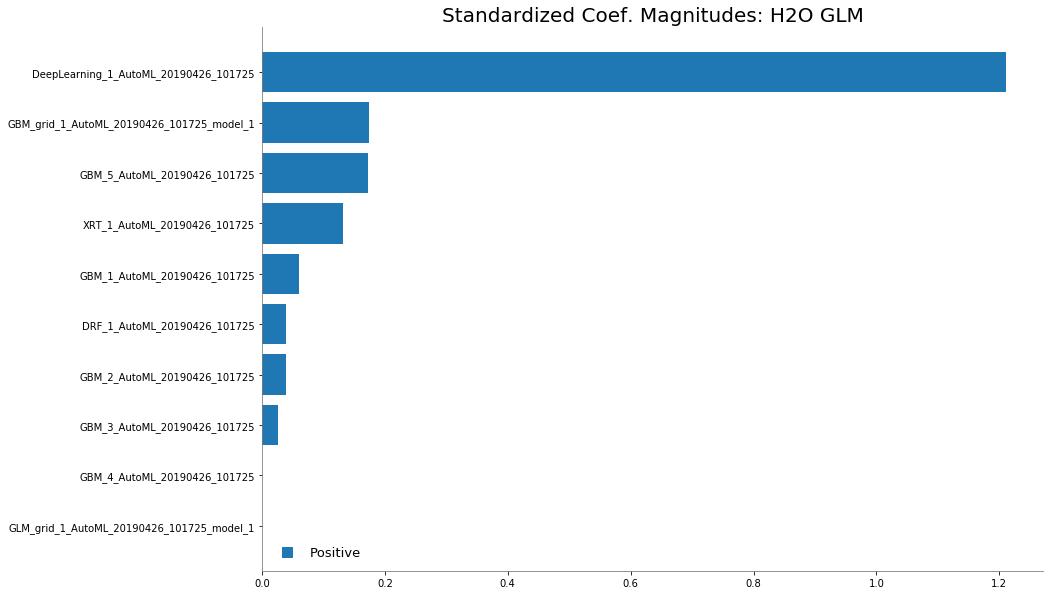

In [0]:
%matplotlib inline
metalearner.std_coef_plot()